#### Install Labraries and Frameworks

In [1]:
!pip install transformers torch
!pip install datasets
!pip install --upgrade torchvision torchaudio torchtext torch
!pip install tqdm


### Import the labraries

In [29]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer,GPTNeoForCausalLM
from datasets import load_dataset
from tqdm import tqdm
import math
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random


### Just check the cuda in pytorch for making easy to evaluate

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load The **Wikitext-2** dataset

In [4]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

## Augmentation

##### **Augmentation** :- Adding some noise into data for checking the perfomance of models ,
For example :

* sample data:  "The quick brown fox jumps over the lazy dog." ,

* modified sample data:  "Thwiiuick brdwn fox jumps olem the layy dog."

In [5]:

def introduce_typos(text, error_rate=0.1):
    text = list(text)
    for i in range(len(text)):
        if random.random() < error_rate:
            text[i] = random.choice("abcdefghijklmnopqrstuvwxyz")
    return "".join(text)

sample_text = "The quick brown fox jumps over the lazy dog."
print("With Typos:", introduce_typos(sample_text))

With Typos: The huickabbown fox jumpstoverkfhe lazy dpg.


### Apply data augmentation to 10%(defult) of the dataset.


In [6]:
modified_texts = [introduce_typos(text) for text in dataset["text"]]
dataset = dataset.add_column("modified_text", modified_texts)


### Apply data augmentation to 5% of the dataset.

In [7]:
modified_texts = [introduce_typos(text,error_rate=0.05) for text in dataset["text"]]
dataset = dataset.add_column("modified_text_5%Error", modified_texts)

In [8]:
dataset

Dataset({
    features: ['text', 'modified_text', 'modified_text_5%Error'],
    num_rows: 4358
})

In [16]:
texts=dataset['text']
text_10=dataset['modified_text']
text_5=dataset['modified_text_5%Error']

## Define **Perplexities** Function

In [9]:
def calculate_perplexity(texts):
    """Compute perplexity of GPT-2 on a batch of texts."""
    perplexities = []
    for text in tqdm(texts, desc="Processing"):
        if not text.strip():
            continue

        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        input_ids = inputs.input_ids.to(device)

        if input_ids.numel() == 0:
            continue

        with torch.no_grad():
            outputs = model(input_ids, labels=input_ids)
            loss = outputs.loss

        perplexity = math.exp(loss.item())
        perplexities.append(perplexity)

    return perplexities

#### print function for **Average** , **MIN** ,
#### **Max** perplexity

In [10]:
def print_Average_Min_Max_perplexity(perplexities):
    avg_perplexity = sum(perplexities) / len(perplexities)
    print(f"\nAverage Perplexity on WikiText-2: {avg_perplexity:.2f}")
    print(f'\nMax Perplexity on WikiText-2: {max(perplexities):.2f}')
    print(f'\nMin Perplexity on WikiText-2: {min(perplexities):.2f}')

# 1. **GPT-2**

#### Create a model object and tokenizer of gpt-2

In [12]:

model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [13]:
model.to(device)

print("GPT-2 model loaded successfully!")

GPT-2 model loaded successfully!


### Make set up the model for Evaluation

In [14]:
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [24]:
perplexities = calculate_perplexity(texts)


Processing: 100%|██████████| 4358/4358 [00:49<00:00, 87.54it/s]


In [18]:
print_Average_Min_Max_perplexity(perplexities)


Average Perplexity on WikiText-2: 569.90

Max Perplexity on WikiText-2: 55536.36

Min Perplexity on WikiText-2: 11.31


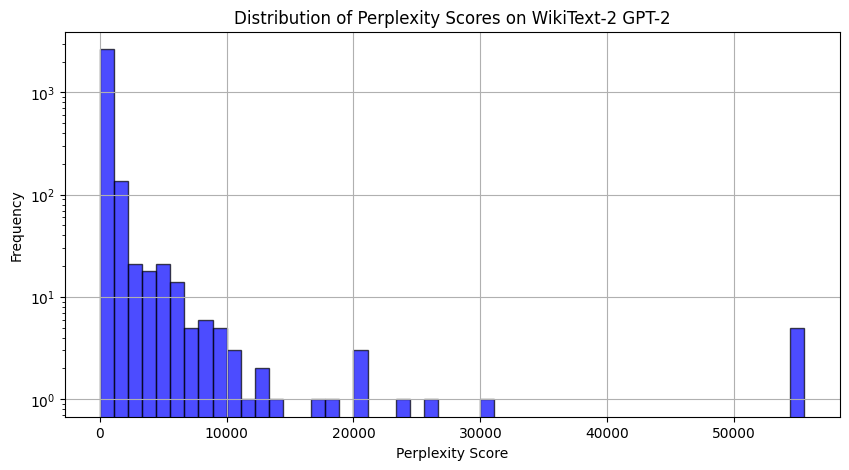

In [25]:
plt.figure(figsize=(10, 5))
plt.hist(perplexities, bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Perplexity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Perplexity Scores on WikiText-2 GPT-2")
plt.yscale("log")
plt.grid(True)

## Adversal Testing

* Augmented **5%** on wikitexts-2

In [20]:
perplexities = calculate_perplexity(text_5)


Processing: 100%|██████████| 4358/4358 [00:59<00:00, 73.84it/s]


In [21]:
print_Average_Min_Max_perplexity(perplexities)


Average Perplexity on WikiText-2: 1305.27

Max Perplexity on WikiText-2: 224692.66

Min Perplexity on WikiText-2: 66.34


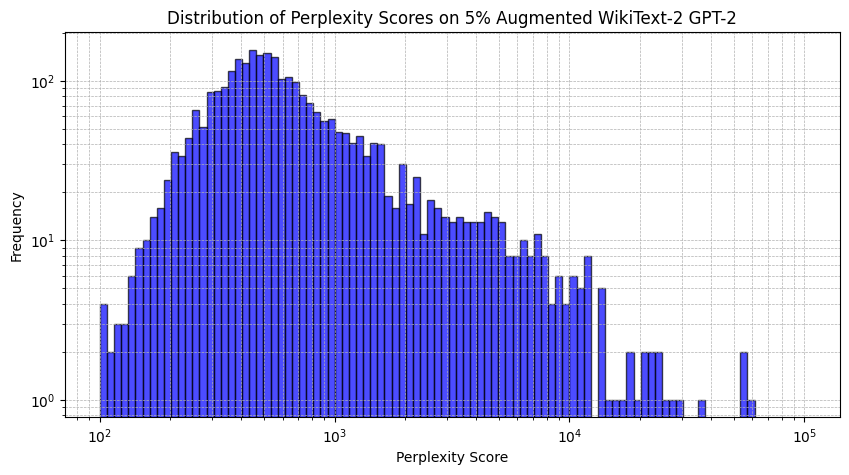

In [23]:

plt.figure(figsize=(10, 5))
plt.hist(perplexities, bins=np.logspace(2, 5, 100), color='blue', alpha=0.7, edgecolor='black')
plt.xscale("log")
plt.xlabel("Perplexity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Perplexity Scores on 5% Augmented WikiText-2 GPT-2")
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()


* Augmented **10%** on Wikitext-2

In [26]:
perplexities = calculate_perplexity(text_10)


Processing: 100%|██████████| 4358/4358 [01:00<00:00, 71.80it/s]


In [27]:
print_Average_Min_Max_perplexity(perplexities)


Average Perplexity on WikiText-2: 1829.93

Max Perplexity on WikiText-2: 55536.36

Min Perplexity on WikiText-2: 75.13


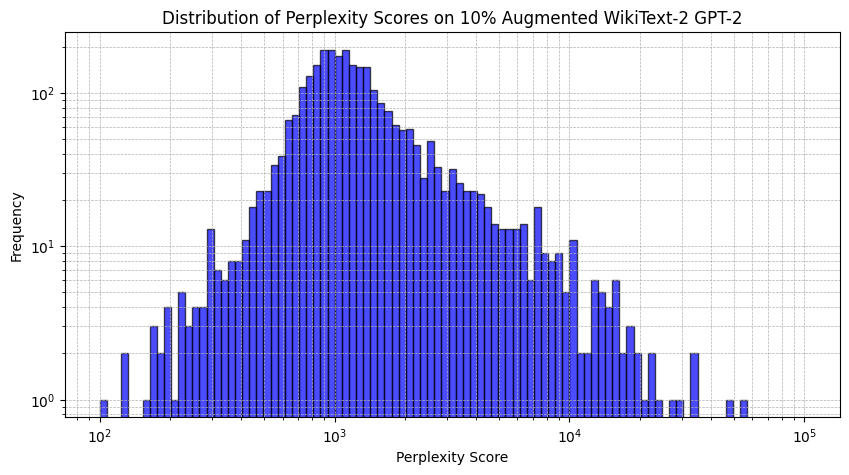

In [28]:

plt.figure(figsize=(10, 5))
plt.hist(perplexities, bins=np.logspace(2, 5, 100), color='blue', alpha=0.7, edgecolor='black')
plt.xscale("log")
plt.xlabel("Perplexity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Perplexity Scores on 10% Augmented WikiText-2 GPT-2")
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

# 2.**GPT-NEO**

In [30]:
model_name = "EleutherAI/gpt-neo-125M"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPTNeoForCausalLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

In [31]:
model.to(device)

print("GPT-neo model loaded successfully!")

GPT-neo model loaded successfully!


#### Set up the model to evaluation mode

In [32]:
model.eval()

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_fe

In [33]:
perplexities = calculate_perplexity(texts)


Processing: 100%|██████████| 4358/4358 [01:03<00:00, 68.22it/s]


In [34]:
print_Average_Min_Max_perplexity(perplexities)


Average Perplexity on WikiText-2: 193.71

Max Perplexity on WikiText-2: 8499.69

Min Perplexity on WikiText-2: 11.94


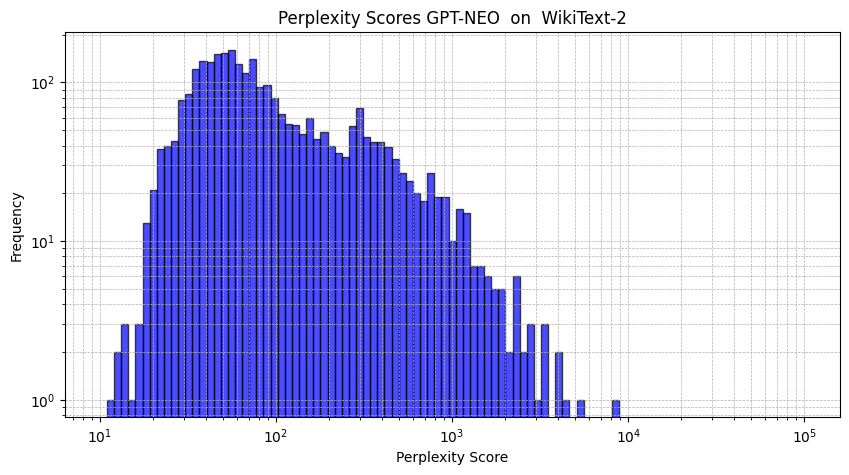

In [35]:
plt.figure(figsize=(10, 5))
plt.hist(perplexities, bins=np.logspace(1, 5, 100), color='blue', alpha=0.7, edgecolor='black')
plt.xscale("log")
plt.xlabel("Perplexity Score")
plt.ylabel("Frequency")
plt.title("Perplexity Scores GPT-NEO  on  WikiText-2")
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

## Adversarial Testing

* Augmented **5%** on wikitext-2

In [36]:
perplexities = calculate_perplexity(text_5)


Processing: 100%|██████████| 4358/4358 [01:10<00:00, 61.41it/s]


In [37]:
print_Average_Min_Max_perplexity(perplexities)


Average Perplexity on WikiText-2: 1033.67

Max Perplexity on WikiText-2: 257185.01

Min Perplexity on WikiText-2: 22.21


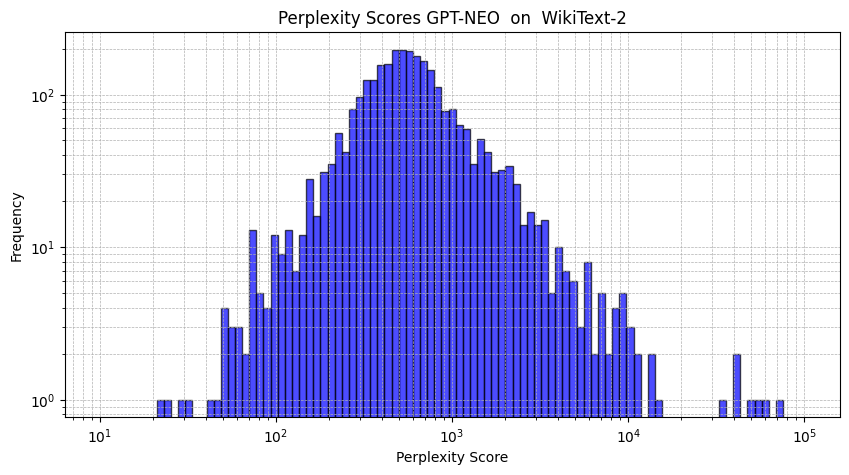

In [38]:
plt.figure(figsize=(10, 5))
plt.hist(perplexities, bins=np.logspace(1, 5, 100), color='blue', alpha=0.7, edgecolor='black')
plt.xscale("log")
plt.xlabel("Perplexity Score")
plt.ylabel("Frequency")
plt.title("Perplexity Scores GPT-NEO  on  WikiText-2")
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()

* Augmented **10%** on wikitext-2

In [39]:
perplexities = calculate_perplexity(text_10)


Processing: 100%|██████████| 4358/4358 [01:20<00:00, 54.19it/s]


In [40]:
print_Average_Min_Max_perplexity(perplexities)


Average Perplexity on WikiText-2: 1537.93

Max Perplexity on WikiText-2: 76879.92

Min Perplexity on WikiText-2: 55.29


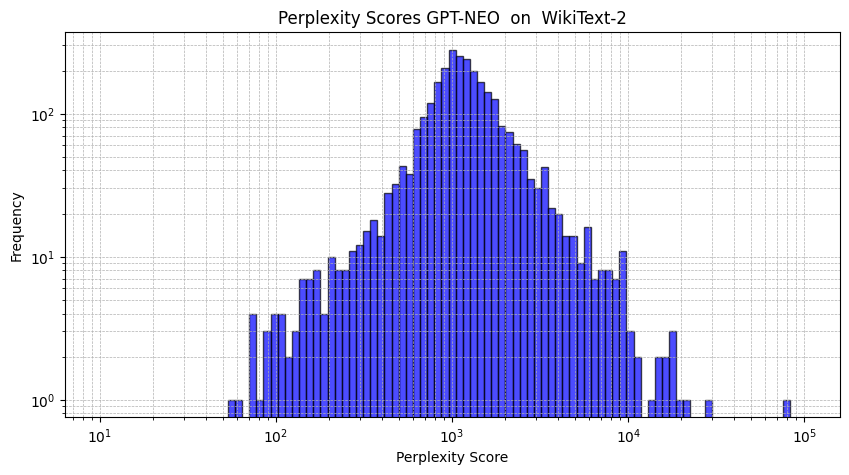

In [41]:
plt.figure(figsize=(10, 5))
plt.hist(perplexities, bins=np.logspace(1, 5, 100), color='blue', alpha=0.7, edgecolor='black')
plt.xscale("log")
plt.xlabel("Perplexity Score")
plt.ylabel("Frequency")
plt.title("Perplexity Scores GPT-NEO  on  WikiText-2")
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()